In [1]:
%pip install raphtory

     ---------------------------------------- 8.6/8.6 MB 4.6 MB/s eta 0:00:00
     ------------------------------------- 756.0/756.0 kB 46.6 MB/s eta 0:00:00
     ---------------------------------------- 1.6/1.6 MB 52.8 MB/s eta 0:00:00
     --------------------------------------- 10.6/10.6 MB 65.5 MB/s eta 0:00:00
     --------------------------------------- 24.6/24.6 MB 46.7 MB/s eta 0:00:00
     ---------------------------------------- 62.6/62.6 kB ? eta 0:00:00
     ---------------------------------------- 65.1/65.1 kB ? eta 0:00:00
     ------------------------------------- 202.9/202.9 kB 12.8 MB/s eta 0:00:00
     ---------------------------------------- 76.7/76.7 kB ? eta 0:00:00
     ------------------------------------- 322.6/322.6 kB 19.5 MB/s eta 0:00:00
     ---------------------------------------- 54.5/54.5 kB ? eta 0:00:00
     ---------------------------------------- 143.8/143.8 kB ? eta 0:00:00
     --------------------------------------- 11.8/11.8 MB 59.5 MB/s eta 0:00


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
%pip install ipywidgets

     -------------------------------------- 139.4/139.4 kB 4.0 MB/s eta 0:00:00
     ---------------------------------------- 2.3/2.3 MB 14.7 MB/s eta 0:00:00
     ---------------------------------------- 214.9/214.9 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
%pip install matplotlib

     ---------------------------------------- 7.6/7.6 MB 61.1 MB/s eta 0:00:00
     ---------------------------------------- 187.6/187.6 kB ? eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 69.9 MB/s eta 0:00:00
     ---------------------------------------- 56.1/56.1 kB ? eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 55.3 MB/s eta 0:00:00
     ---------------------------------------- 103.1/103.1 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
"""
Dead Code - use main.rs file to preprocess the data instead
"""

# Import necessary libraries
import pandas as pd

def preprocess_and_load_data(filepath):
    """
    Load and preprocess call graph data from a CSV file.
    
    This function performs several preprocessing steps on call graph data, including:
    1. Loading specific columns from the CSV file.
    2. Removing rows containing specific unwanted values.
    3. Handling missing values by removing rows with any NaN values.
    4. Ensures the 'timestamp' column is of type int64. (Otherwise Raphtory would throw the "Source and Target columns must be either u64 or text, Time column must be i64." error)
    
    The columns to be loaded and their respective data types are predefined within the function. The unwanted values that are to be removed are also predefined.
    
    Parameters:
    file_path (str): The path to the CSV file.
    
    Returns:
    pd.DataFrame: A pandas DataFrame containing the preprocessed call graph data.
    
    Note:
    The function assumes that the input CSV file adheres to a specific structure and contains specific columns. If the CSV file differs significantly from this expected structure, the function may not perform correctly.
    """

    # Define the columns that need to be loaded
    columns = ["timestamp", "um", "dm"]

    # Define data types for each column
    data_types = {
        "timestamp": int,
        "um": str,
        "dm": str,
    }

    # Load the data
    call_graph_df = pd.read_csv(filepath, usecols=columns, dtype=data_types)

    # Remove rows with unwanted values & Filter out rows that have any NaN values
    unwanted_values=["UNKNOWN", "UNAVAILABLE"]
    call_graph_df = call_graph_df[~call_graph_df.isin(unwanted_values).any(axis=1)].copy()
    call_graph_df = call_graph_df.dropna()

    # Ensure 'timestamp' column is int64
    call_graph_df['timestamp'] = call_graph_df['timestamp'].astype('int64')

    return call_graph_df

In [ ]:
"""
Dead Code - use the cell below to load the data instead
"""

import os
import pandas as pd
from raphtory import Graph

base_filepath = 'c:/Users/mf479/Desktop/Alibaba-CallGraph/CallGraph_{}.csv'
start_file_number = 0
end_file_number = 5

# Initialise an empty Raphtory graph
g = Graph()

for file_number in range(start_file_number, end_file_number + 1):
    filepath = base_filepath.format(file_number)
    if os.path.exists(filepath):
        # Preprocess the data and load into a DataFrame
        call_graph_df = preprocess_and_load_data(filepath)
        
        # Load the data from the DataFrame into the Raphtory graph
        g.load_edges_from_pandas(
            df=call_graph_df,
            src="um",
            dst="dm",
            time="timestamp",
        )
    else:
        print(f"File does not exist: {filepath}")

print(g)

In [ ]:
import os

# Save the file
absolute_save_path = os.path.abspath("saved_graph")
g.save_to_file(absolute_save_path)

# Load the file
#if os.path.isfile(absolute_save_path):
#    loaded_graph = Graph.load_from_file(absolute_save_path)
#    print(loaded_graph)
#else:
#    print(f"File does not exist: {absolute_save_path}")

In [4]:
import os
import pandas as pd
from raphtory import Graph
import time
start_time = time.time()  # Start timing
base_filepath = 'C:/Users/maruf/OneDrive/Desktop/CallingGraph/CallGraph_{}.csv'
start_file_number = 0
end_file_number = 4

# Initialise an empty Raphtory graph
g = Graph()

for file_number in range(start_file_number, end_file_number + 1):
    filepath = base_filepath.format(file_number)
    if os.path.exists(filepath):
        # Load into pandas
        call_graph_df = pd.read_csv(filepath)
        
        # Load the data from the DataFrame into the Raphtory graph
        g.load_edges_from_pandas(
            df=call_graph_df,
            src="um",
            dst="dm",
            time="timestamp",
        )
    else:
        print(f"File does not exist: {filepath}")

end_time = time.time()  # End timing
print(g)
print(f"Total execution time: {end_time - start_time} seconds")

Graph(number_of_edges=78626, number_of_vertices=22764, number_of_temporal_edges=51914945, earliest_time="1", latest_time="899999")
Total execution time: 143.8598494529724 seconds


In [ ]:
import os

# Save the file
absolute_save_path = os.path.abspath("saved_graph")
g.save_to_file(absolute_save_path)

In [ ]:
# Load the file
if os.path.isfile(absolute_save_path):
    loaded_graph = Graph.load_from_file(absolute_save_path)
    print(loaded_graph)
else:
    print(f"File does not exist: {absolute_save_path}")

In [ ]:
dataset = pd.read_csv("C:/Users/maruf/OneDrive/Desktop/CallingGraph/CallGraph_1.csv")
dataset.head()

In [ ]:
import os
print("Current Working Directory:", os.getcwd())

# Analysis

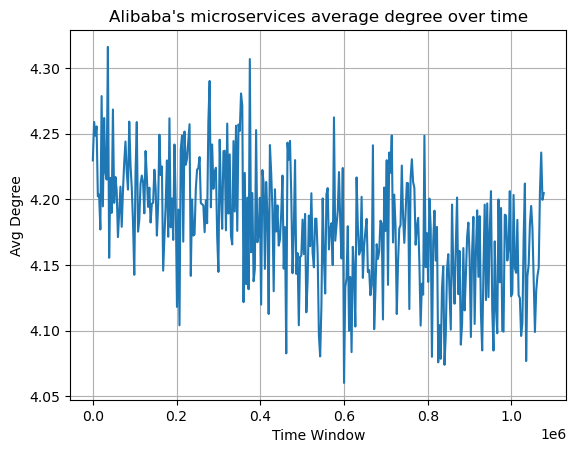

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

avg_degree = []
time = []

for windowed_graph in g.rolling(window=3000):
    result = rp.average_degree(windowed_graph)
    avg_degree.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, avg_degree)
plt.xlabel("Time Window")
plt.ylabel("Avg Degree")
plt.title("Alibaba's microservices average degree over time")
plt.grid(True)

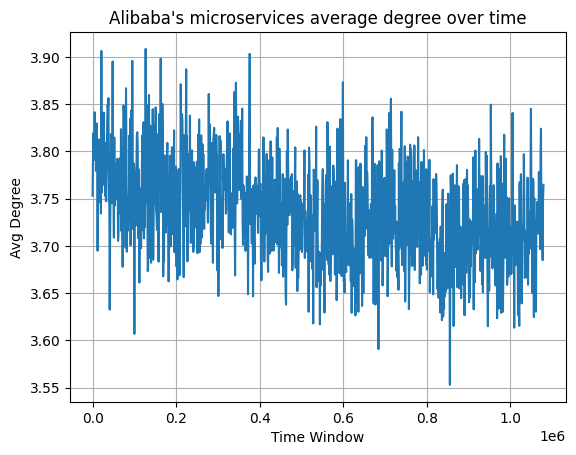

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

avg_degree = []
time = []

for windowed_graph in g.rolling(window=1000):
    result = rp.average_degree(windowed_graph)
    avg_degree.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, avg_degree)
plt.xlabel("Time Window")
plt.ylabel("Avg Degree")
plt.title("Alibaba's microservices average degree over time")
plt.grid(True)

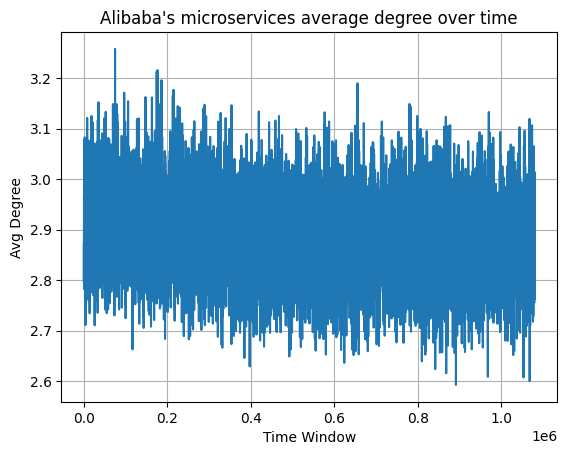

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

avg_degree = []
time = []

for windowed_graph in g.rolling(window=100):
    result = rp.average_degree(windowed_graph)
    avg_degree.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, avg_degree)
plt.xlabel("Time Window")
plt.ylabel("Avg Degree")
plt.title("Alibaba's microservices average degree over time")
plt.grid(True)

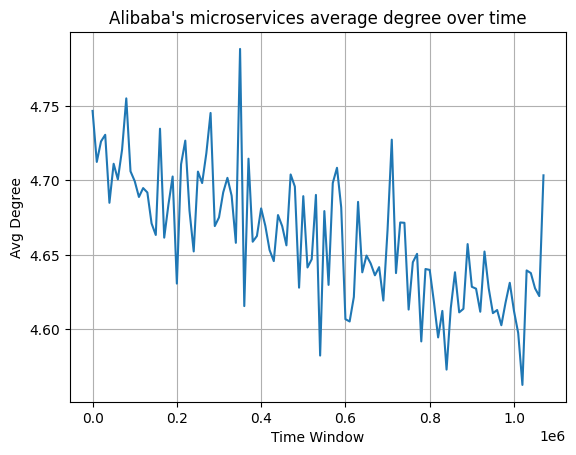

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

avg_degree = []
time = []

for windowed_graph in g.rolling(window=10000):
    result = rp.average_degree(windowed_graph)
    avg_degree.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, avg_degree)
plt.xlabel("Time Window")
plt.ylabel("Avg Degree")
plt.title("Alibaba's microservices average degree over time")
plt.grid(True)

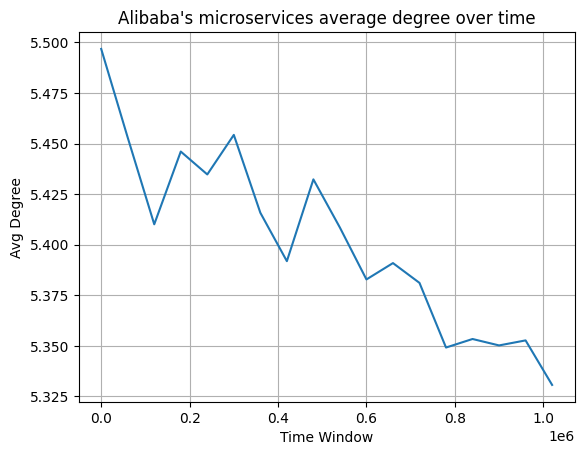

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

avg_degree = []
time = []

for windowed_graph in g.rolling(window=60000):
    result = rp.average_degree(windowed_graph)
    avg_degree.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, avg_degree)
plt.xlabel("Time Window")
plt.ylabel("Avg Degree")
plt.title("Alibaba's microservices average degree over time")
plt.grid(True)

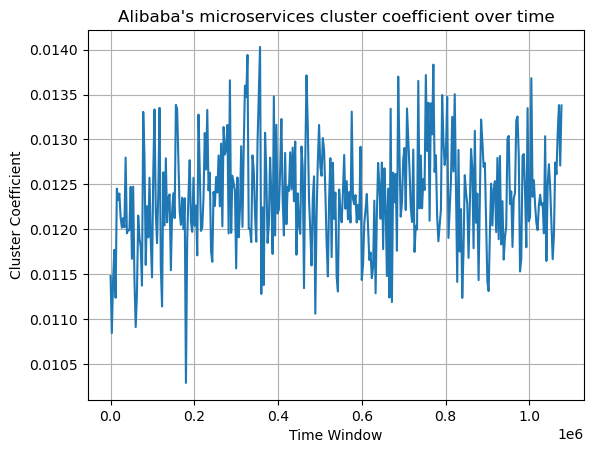

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

clstr_cfsnt = []
time = []

for windowed_graph in g.rolling(window=3000):
    result = rp.global_clustering_coefficient(windowed_graph)
    clstr_cfsnt.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, clstr_cfsnt)
plt.xlabel("Time Window")
plt.ylabel("Cluster Coefficient")
plt.title("Alibaba's microservices cluster coefficient over time")
plt.grid(True)

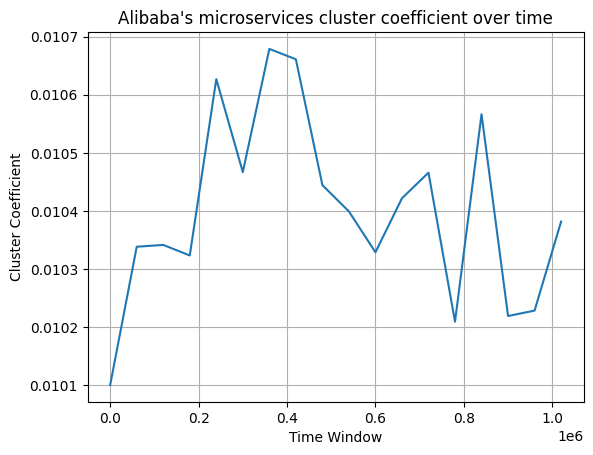

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

clstr_cfsnt = []
time = []

for windowed_graph in g.rolling(window=60000):
    result = rp.global_clustering_coefficient(windowed_graph)
    clstr_cfsnt.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, clstr_cfsnt)
plt.xlabel("Time Window")
plt.ylabel("Cluster Coefficient")
plt.title("Alibaba's microservices cluster coefficient over time")
plt.grid(True)

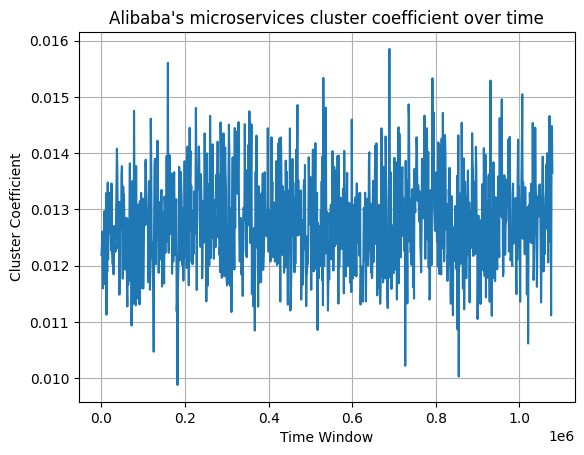

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

clstr_cfsnt = []
time = []

for windowed_graph in g.rolling(window=1000):
    result = rp.global_clustering_coefficient(windowed_graph)
    clstr_cfsnt.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, clstr_cfsnt)
plt.xlabel("Time Window")
plt.ylabel("Cluster Coefficient")
plt.title("Alibaba's microservices cluster coefficient over time")
plt.grid(True)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

clstr_cfsnt = []
time = []

for windowed_graph in g.rolling(window=3000):
    result = rp.global_clustering_coefficient(windowed_graph)
    clstr_cfsnt.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, clstr_cfsnt)
plt.xlabel("Time Window")
plt.ylabel("Cluster Coefficient")
plt.title("Alibaba's microservices cluster coefficient over time")
plt.grid(True)

In [ ]:
from raphtory import algorithms as rp

print(rp.max_degree(g))

4411


In [ ]:
results = rp.pagerank(g)

top_5 = results.top_k(5)
for rank, (name,score) in enumerate(top_5, 1):
    print(f"Rank {rank}: {name} with a score of {score:.5f}")

Rank 1: MS_27421 with a score of 0.03337
Rank 2: MS_37691 with a score of 0.01820
Rank 3: MS_2827 with a score of 0.00753
Rank 4: MS_46825 with a score of 0.00525
Rank 5: MS_21883 with a score of 0.00335


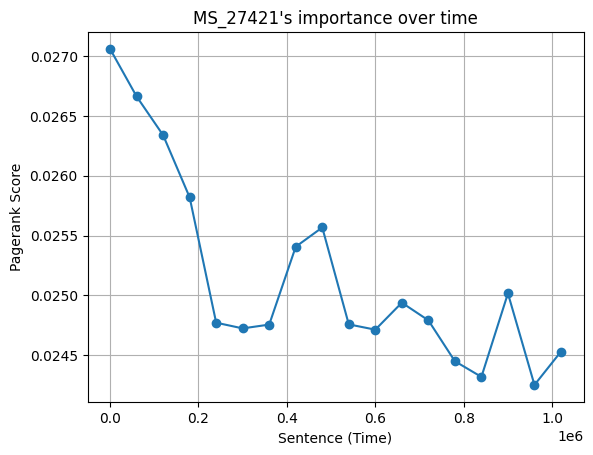

In [ ]:
# mkdocs: render
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

importance = []
time = []

for windowed_graph in g.rolling(window=60000):
    result = rp.pagerank(windowed_graph)
    importance.append(result.get("MS_27421"))
    time.append(windowed_graph.earliest_time)

plt.plot(time, importance, marker="o")
plt.xlabel("Sentence (Time)")
plt.ylabel("Pagerank Score")
plt.title("MS_27421's importance over time")
plt.grid(True)

In [ ]:
import raphtory.export as ex
import json

pyvis_g = ex.to_pyvis(
    traffic_graph, edge_weight="data_size_MB", edge_color="#8e9b9e", directed=True
)

options = {
    "edges": {
        "scaling": {
            "min": 1,
            "max": 10,
        },
    },
    "physics": {
        "barnesHut": {
            "gravitationalConstant": -30000,
            "centralGravity": 0.3,
            "springLength": 100,
            "springConstant": 0.05,
        },
        "maxVelocity": 50,
        "timestep": 0.5,
    },
}

pyvis_g.set_options(json.dumps(options))

pyvis_g.show("nx.html")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def setup_plot():
    """
    Initialize the plot with labels, axes, etc.
    """
    plt.figure(figsize=(8, 4))
    plt.xlabel('Time')
    plt.ylabel("Microservices' names")
    plt.title('Temporal Network Diagram')
    plt.grid(False)  # Turn off grid as it is not shown in the original diagram

def plot_horizontal_line(node, y_position):
    """
    Plot a horizontal line for the node at the given y_position using the node's colour.
    """
    colour = node_colours.get(node, 'lightgrey')  # Default to 'lightgrey' if node colour not specified
    plt.hlines(y_position, xmin=0, xmax=10, colours=colour, linestyles='solid', lw=2)

def plot_interaction(source, target, time, y_positions):
    """
    Plot an interaction with a dot and a connecting line.
    Source and target are the node labels, time is the x position.
    All edges/interactions are in black colour.
    """
    # Plot a dot for the upstream microservice
    plt.plot(time, y_positions[source], 'o', colour=node_colours[source], markersize=10)

    # Plot a dot for the target if different from the source
    if source != target:
        plt.plot(time, y_positions[target], 'o', colour=node_colours[target], markersize=10)
        source_pos = y_positions[source]
        target_pos = y_positions[target]
        # Choose whether the arc goes up or down based on source and target positions
        arc_height = -0.2 if source_pos < target_pos else 0.2
        # Create a patch for the arc
        arc = mpatches.FancyArrowPatch((time, source_pos), (time, target_pos),
                                       connectionstyle=f"arc3,rad={arc_height}",
                                       colour='black', lw=1)
        plt.gca().add_patch(arc)

def finalize_plot():
    """
    Display the plot or save it to a file.
    """
    plt.yticks(range(len(nodes)), nodes)  # Set the y-ticks to node labels
    plt.xticks(range(11))  # Assuming the time points are integers from 0 to 10
    plt.xlim(0, 10)  # Set the x-axis limits
    plt.ylim(-1, len(nodes))  # Set the y-axis limits to include all nodes
    plt.tight_layout()
    plt.show()

# Sample usage with mock data
nodes = ['MS_6732', 'B', 'C', 'D', 'E', 'F']
interactions = [
    ('MS_6732', 'C', 1),
    ('MS_6732', 'B', 2),
    ('E', 'MS_6732', 6),
    # More interactions would be added here...
]

# Define a colour mapping for each node
node_colours = {
    'MS_6732': 'red',
    'B': 'blue',
    'C': 'green',
    'E': 'yellow',
}

# Assign each node a y-position for plotting
y_positions = {node: i for i, node in enumerate(nodes)}

# Set up the plot
setup_plot()

# Plot the nodes
for node in y_positions:
    plot_horizontal_line(node, y_positions[node])

# Plot the interactions
for interaction in interactions:
    plot_interaction(*interaction, y_positions=y_positions)

# Finalize and show the plot
finalize_plot()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def generate_colours(num_nodes, cmap_name='viridis'):
    """ Generate distinct colors for each node using a colormap. """
    colour_map = matplotlib.colormaps[cmap_name]
    return [colour_map(i / num_nodes) for i in range(num_nodes)]

def setup_plot():
    """
    Initialize the plot with labels, axes, etc.
    """
    plt.figure(figsize=(8, 4))
    plt.xlabel('Time')
    plt.ylabel("Microservices' names")
    plt.title('Temporal Network Diagram')
    plt.grid(False)

def plot_horizontal_line(y_position, colour):
    """
    Plot a horizontal line for the node at the given y_position using the node's colour.
    """
    plt.hlines(y_position, xmin=0, xmax=10, colors=colour, linestyles='solid', lw=2)

def plot_interaction(source, target, time, y_positions, node_colours):
    """
    Plot an interaction with a dot and a connecting line.
    Source and target are the node labels, time is the x position.
    All edges/interactions are in black colour.
    """
    # Plot a dot for the upstream microservice
    plt.plot(time, y_positions[source], 'o', color=node_colours[source], markersize=10)

    # Plot a dot for the target if different from the source
    if source != target:
        plt.plot(time, y_positions[target], 'o', color=node_colours[target], markersize=10)
        source_pos = y_positions[source]
        target_pos = y_positions[target]
        # Choose whether the arc goes up or down based on source and target positions
        arc_height = -0.2 if source_pos < target_pos else 0.2
        # Create a patch for the arc
        arc = mpatches.FancyArrowPatch((time, source_pos), (time, target_pos),
                                       connectionstyle=f"arc3,rad={arc_height}",
                                       color='black', lw=1)
        plt.gca().add_patch(arc)

def finalize_plot(nodes):
    """
    Display the plot or save it to a file.
    """
    plt.yticks(range(len(nodes)), nodes)  # Set the y-ticks to node labels
    plt.xticks(range(11))  # Set the time points integers from 0 to 10
    plt.xlim(0, 10)  # Set the x-axis limits
    plt.ylim(-1, len(nodes))  # Set the y-axis limits to include all nodes
    plt.tight_layout()
    plt.show()


# Generating some numbers of nodes and interactions
num_nodes = 10 #len(ms) in raphtory
nodes = [f'MS_{i}' for i in range(num_nodes)]
colours = generate_colours(num_nodes)

# Create a dictionary to map nodes to colours
node_colours = {node: colour for node, colour in zip(nodes, colours)}

# Sample usage with mock data
#nodes = ['MS_6732', 'B', 'C', 'D', 'E', 'F']
interactions = [
    ('MS_2', 'MS_5', 1),
    ('MS_2', 'MS_8', 2),
    ('MS_5', 'MS_6', 6),
]

# Assign each node a y-position for plotting
y_positions = {node: i for i, node in enumerate(nodes)}

# Set up the plot
setup_plot()

# Plot the nodes
for node in nodes:
    plot_horizontal_line(y_positions[node], node_colours[node])

# Plot the interactions
for source, target, time in interactions:
    plot_interaction(source, target, time, y_positions, node_colours)

# Finalize and show the plot
finalize_plot(nodes)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import numpy as np

class TemporalNetworkDiagram:
    def __init__(self, num_nodes, interactions, earliest_time=0, latest_time=20, filename='temporal_network_diagram.png'):
        self.num_nodes = num_nodes
        self.nodes = [f'MS_{i}' for i in range(num_nodes)]
        self.interactions = interactions
        self.filename = filename
        self.latest_time = latest_time
        self.earliest_time = earliest_time
        self.node_colours = self.generate_colours()
        self.y_positions = self.assign_y_positions()

    def generate_colours(self, cmap_name='hsv'): # If the set of colours in hsv is not satisfactory change to "set1"
        """ 
        Generate random distinct colors for each node using a colormap. 
        """
        colour_map = matplotlib.colormaps[cmap_name]
        return {node: colour_map(random.random()) for node in self.nodes}

    def assign_y_positions(self):
        return {node: i for i, node in enumerate(self.nodes)}

    def setup_plot(self):
        """
        Initialize the plot with labels, axes, etc.
        """
        plt.figure(figsize=(60, 28))
        plt.xlabel('Time')
        plt.ylabel("Microservices' names")
        plt.title('Temporal Network Diagram')
        plt.grid(False)

    def plot_horizontal_line(self, y_position, colour):
        """
        Plot a horizontal line for the node at the given y_position using the node's colour.
        """
        plt.hlines(y_position, xmin=0, xmax=self.latest_time, colors=colour, linestyles='solid', lw=2)

    def plot_interaction(self, source, target, time):
        """
        Plot an interaction with a dot and a connecting line.
        Source and target are the node labels, time is the x position.
        All edges/interactions are in black colour.
        """
        # Plot a dot for the upstream microservice
        plt.plot(time, self.y_positions[source], 'o', color=self.node_colours[source], markersize=10)
        # Plot a dot for the target if different from the source
        if source != target:
            plt.plot(time, self.y_positions[target], 'o', color=self.node_colours[target], markersize=10)
            source_pos, target_pos = self.y_positions[source], self.y_positions[target]
            # Choose whether the arc goes up or down based on source and target positions
            arc_height = -0.2 if source_pos < target_pos else 0.2
            # Create a patch for the arc
            arc = mpatches.FancyArrowPatch((time, source_pos), (time, target_pos), 
                                           connectionstyle=f"arc3,rad={arc_height}", 
                                           color='black', lw=1)
            plt.gca().add_patch(arc)

    def finalize_plot(self):
        """
        Display the plot and save it to a file.
        """
        # Set the y-ticks to node labels
        plt.yticks(range(len(self.nodes)), self.nodes) 
        # Set the time points integers from 0 to 10
        plt.xticks(range(self.latest_time + 1))
        # Set the x-axis limits
        plt.xlim(self.earliest_time, self.latest_time + 1)
        # Set the y-axis limits to include all nodes
        plt.ylim(-1, len(self.nodes))
        plt.tight_layout()
        # Saves the plot as a file
        plt.savefig(self.filename)
        # Display the diagram
        plt.show()

    def create_diagram(self):
        self.setup_plot()
        for node in self.nodes:
            self.plot_horizontal_line(self.y_positions[node], self.node_colours[node])
        for source, target, time in self.interactions:
            self.plot_interaction(source, target, time)
        self.finalize_plot()

# Mock data
num_nodes = 70
interactions = [
    ('MS_2', 'MS_5', 8),
    ('MS_2', 'MS_8', 4),
    ('MS_5', 'MS_6', 6),
    ('MS_23', 'MS_39', 19)
]

# Example usage
diagram = TemporalNetworkDiagram(num_nodes, interactions, earliest_time=20, latest_time=40)
diagram.create_diagram()